# Auto-diff with JAX

https://github.com/google/jax

JAX is a Google research project, developed by the former developers of [Autograd](https://github.com/hips/autograd), bringing together the potentialities of Autograd and the linear algebra accelerator [XLA](https://www.tensorflow.org/xla). It is based on three pillars(we only use the first two..):
- `grad`: Automatic Differentiation
- `jit`: Just-in-time compilation
- `vmap`: Automatic vectorization.

## Automatic differentiation in JAX

JAX augments numpy and Python code with function transformations which make it trivial to perform operations common in machine learning programs. JAX's augmented numpy lives at `jax.numpy`. With a few exceptions, you can think of `jax.numpy` as directly interchangeable with `numpy`. As a general rule, you should use `jax.numpy` whenever you plan to use any of JAX's transformations.

The function `df = jax.grad(f, argnums = 0)` takes the callable object `f` and returns another callable object, `df`, evaluating the gradient of `f` w.r.t. the argument(s) of index(es) `argnums`. For more information, check out the [documentation](https://jax.readthedocs.io/en/latest/jax.html?highlight=grad#jax.grad).



**Example**

We consider the function:
$$
f(x) = x \sin(x^2)
$$

and we compute $f'(x_0)$ for $x_0 = 0.13$

In [28]:
import numpy as np
import jax.numpy as jnp #we have to use the model numpy of jax(clone of numpy that can be use by jax)
import jax

func = lambda x : x * jnp.sin(x**2) #we have to use the module jnp for the sinus
x0 = 0.13
dfunc_AD = jax.grad(func) #grad take as input also argnums which is the index of the input of f w.r.t which we want to compute the derivative
df_AD = dfunc_AD(x0)

# analytical derivative
dfunc = lambda x : np.sin(x**2)+2 * x**2 * np.cos(x**2)
df_ex = dfunc(x0)

print('df (ex): %f' % df_ex)
print('df (AD): %f' % df_AD)

print('err (AD): %e' % (abs(df_AD - df_ex)/abs(df_ex)))

df (ex): 0.050694
df (AD): 0.050694
err (AD): 7.348529e-08


# Artificial-Neural-Network gradient computation in JAX

Forget for a wile about JAX. We want to build a fully connected ANN with the architecture shown below (1 input, 1 output, 2 hidden layers with 4 and 3 neurons respectively), with `tanh` as activation function.

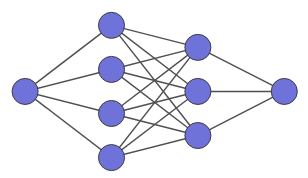

The ANN can be written as (a combination of...)
$$
y = ANN(x) = W_3  \tanh( W_2 \tanh (W_1 x - b_1) - b_2) - b_3
$$
First, randomly define the weights and biases.

In [35]:
params = [
          #layer1
          np.random.randn(4),     # W1
          np.random.randn(4),     # b1
          #layer2
          np.random.randn(3,4),     # W2
          np.random.randn(3),     # b2
          #layer3
          np.random.randn(3),     # W3
          np.random.randn(),     # b3
         ]

Then, define the function `ANN`, and compute `ANN`(1.0).

In [36]:
def ANN(x, params):
  #x is the inputs and params containing weights and biases
  W1, b1, W2, b2, W3, b3 = params
  hidden1 = np.tanh(np.dot(W1,x) - b1) # 1st hidden layer
  hidden2 = np.tanh(np.dot(W2,hidden1) - b2)
  return np.dot(W3, hidden2) -b3

ANN(1.0 , params)

0.8800119619870052

### Gradients computation

Now, rewrite the function `ANN` using the JAX's augmented `numpy`.
Compute again `ANN`(1.0), and compute the derivative of `ANN` w.r.t. `x` using `jax.grad`. Evaluate the result in `x` = 1.0.

In [37]:
def ANN(x, params):
  #x is the inputs and params containing weights and biases
  W1, b1, W2, b2, W3, b3 = params
  hidden1 = jnp.tanh(jnp.dot(W1,x) - b1) # 1st hidden layer
  hidden2 = jnp.tanh(jnp.dot(W2,hidden1) - b2)
  return jnp.dot(W3, hidden2) -b3

print( ANN(1.0 , params) )
dANN = jax.grad(ANN)
print(dANN(1.0, params))

0.8800121
-0.5830726


Plot the graph of the function `ANN` and of its first derivative in the interval $x \in [-10, 10]$.

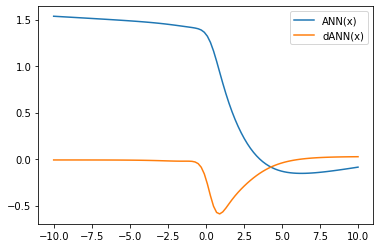

In [38]:
import matplotlib.pyplot as plt
xx = np.linspace(-10, 10, num=100)
plt.plot(xx,[ANN(x,params) for x in xx], label= 'ANN(x)')
plt.plot(xx,[dANN(x,params) for x in xx], label= 'dANN(x)')
plt.legend()

Compute the gradient of `ANN` w.r.t. the neural network parameters.

In [40]:
dANN_params = jax.grad(ANN, argnums = 1)  #derivative wrt the params
res = dANN_params(1.0, params) #same shape of the list of objects params
res[2] 

DeviceArray([[-9.0786787e-03,  2.4348617e-02,  2.1147481e-01,
              -2.3341700e-01],
             [ 3.4136962e-02, -9.1553837e-02, -7.9517162e-01,
               8.7767702e-01],
             [-8.7074738e-04,  2.3353063e-03,  2.0282812e-02,
              -2.2387316e-02]], dtype=float32)

Evaluate the execution times of the function `ANN` and of the functions computing gradients by the magic command `%timeit`

In [41]:
%timeit ANN(1.0, params)
%timeit dANN(1.0, params)
%timeit dANN_params(1.0, params)

The slowest run took 8.85 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 5: 45.7 µs per loop
100 loops, best of 5: 6.24 ms per loop
100 loops, best of 5: 7.25 ms per loop


### Speed it up with JIT!

Compile the function `ANN` and the functions that compute its gradients using the [just-in-time compilation](https://en.wikipedia.org/wiki/Just-in-time_compilation) utility `jax.jit`. 

With `f_jit = jax.jit(f)` a callable `f` is compiled into `f_jit`.

Then, check that the compiled `ANN` function returns the same results as the original one. Finally, evaluate the execution times and compare it with the previous results.

In [42]:
ANN_jit = jax.jit(ANN)
dANN_jit = jax.jit(dANN)
dANN_params_jit = jax.jit(dANN_params)

In [44]:
#using jit the performance increase a lot 
#for dANN we have performance of the order of microseconds againts milliseconds achieved with only jax
%timeit ANN_jit(1.0, params)
%timeit dANN_jit(1.0, params)
%timeit dANN_params_jit(1.0, params)

The slowest run took 81.07 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 5: 13.3 µs per loop
The slowest run took 51.57 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 5: 13.4 µs per loop
The slowest run took 7.10 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 5: 16.9 µs per loop
